In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats 

 99% 808M/812M [00:05<00:00, 186MB/s]
100% 812M/812M [00:05<00:00, 167MB/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import zipfile
import os , shutil
import matplotlib.pyplot as plt

In [5]:
#zip_ref = zipfile.ZipFile('/content/test1.zip', 'r')
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [6]:
zip_ref = zipfile.ZipFile('/content/files/train.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [7]:
original_dataset_dir = "/content/files/train"

base_dir = '/content/data'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(6500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(6500, 7500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(7500, 9000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(6500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(6500, 7500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(7500, 9000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
print('Train set --- Number of cat image:', len(os.listdir(train_cats_dir)))
print('Test set --- Number of cat image::', len(os.listdir(test_cats_dir)))
print('Validation set--- Number of cat image:', len(os.listdir(validation_cats_dir)))
print('Train set --- Number of dog image:', len(os.listdir(train_dogs_dir)))
print('Test set --- Number of dog image:', len(os.listdir(test_dogs_dir)))
print('Validation set --- Number of dog image:', len(os.listdir(validation_dogs_dir)))

Train set --- Number of cat image: 6500
Test set --- Number of cat image:: 1500
Validation set--- Number of cat image: 1000
Train set --- Number of dog image: 6500
Test set --- Number of dog image: 1500
Validation set --- Number of dog image: 1000


# LeNet-5

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from keras.layers.serialization import activation

lenet_model = Sequential()

#C1 Convolution Layer 
lenet_model.add(Conv2D(filters = 6,kernel_size=5, strides = 1, activation="tanh",
                       input_shape=(28,28,3),padding="same"))

#S2 Pooling Layer
lenet_model.add(AveragePooling2D(pool_size = 2, strides = 2, padding = "valid"))

#C3 Convolution Layer 
lenet_model.add(Conv2D(filters = 16,kernel_size=5, strides = 1, activation="tanh", padding="valid"))

#S4 Pooling Layer
lenet_model.add(AveragePooling2D(pool_size = 2, strides = 2, padding = "valid"))

#C5 Convolution Layer 
lenet_model.add(Conv2D(filters = 120, kernel_size=5, strides = 1, activation="tanh", padding="valid"))

lenet_model.add(Flatten())

#FC6 Fully Connected Layer
lenet_model.add(Dense(units = 84, activation="tanh"))

#FC7 Fully Connected Layer
lenet_model.add(Dense(units = 1, activation="sigmoid"))

In [10]:
lenet_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [11]:
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

### Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(28, 28),
        batch_size=32,.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(28, 28),
        batch_size=32,
        class_mode='binary')


Found 13000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
lenet_history = lenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator)

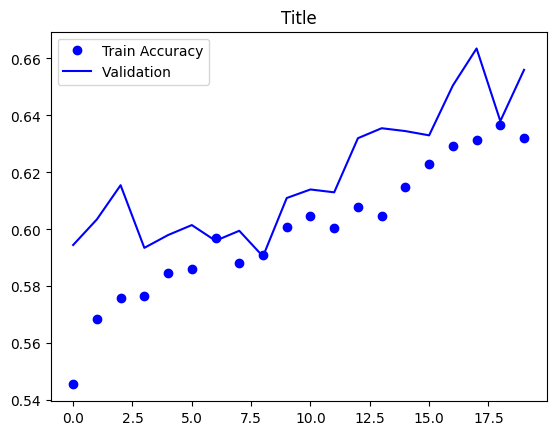

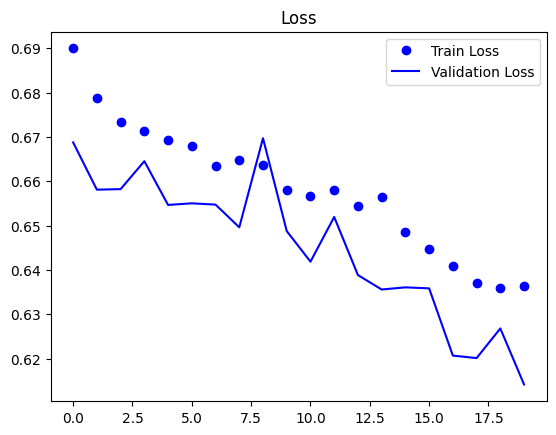

In [20]:
acc = lenet_history.history['accuracy']
val_acc = lenet_history.history['val_accuracy']
loss = lenet_history.history['loss']
val_loss = lenet_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation ')
plt.title('Title')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

# AlexNet

In [44]:
IMG_SIZE = (227, 227)
BATCH_SIZE = 32
train_data= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              label_mode="binary",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="binary",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 13000 files belonging to 2 classes.
Found 3000 files belonging to 2 classes.


In [45]:
from keras.api._v2.keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense,Activation,MaxPool2D, BatchNormalization, Dropout,Rescaling
from keras.layers import RandomFlip, RandomRotation,RandomZoom
from keras.regularizers import l2

In [46]:
alexNet_model = Sequential()
#dataaugmentation
alexNet_model.add(Rescaling(1./255))
alexNet_model.add(RandomFlip("horizontal"))
alexNet_model.add(RandomRotation(0.2))
alexNet_model.add(RandomZoom(0.2))

# 1st layer (conv + pool + batchnorm)
alexNet_model.add(Conv2D(filters= 96, 
                         kernel_size= (11,11), 
                         strides=(4,4), 
                         padding='valid', 
                         kernel_regularizer=l2(0.0005) #l2 regularizer
                         ))

alexNet_model.add(Activation('relu'))  #activation function can be added on its own layer
alexNet_model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
alexNet_model.add(BatchNormalization())
    
# 2nd layer (conv + pool + batchnorm)
alexNet_model.add(Conv2D(filters=256,
                 kernel_size=(5,5),
                 strides=(1,1),
                 padding='same',
                 kernel_regularizer=l2(0.0005)))
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
alexNet_model.add(BatchNormalization())
            
# layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
alexNet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
alexNet_model.add(Activation('relu'))
alexNet_model.add(BatchNormalization())
        
# layer 4 (conv + batchnorm)      <--- similar to layer 3
alexNet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
alexNet_model.add(Activation('relu'))
alexNet_model.add(BatchNormalization())
            
# layer 5 (conv + batchnorm)  
alexNet_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
alexNet_model.add(Activation('relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# Flatten the CNN output to feed it with fully connected layers
alexNet_model.add(Flatten())

# layer 6 (Dense layer + dropout)  
alexNet_model.add(Dense(units = 4096, activation = 'relu'))
alexNet_model.add(Dropout(0.5))

# layer 7 (Dense layers) 
alexNet_model.add(Dense(units = 4096, activation = 'relu'))
alexNet_model.add(Dropout(0.5))
                           
# layer 8 (softmax output layer) 
alexNet_model.add(Dense(units = 1, activation = 'sigmoid'))

In [47]:
alexNet_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [48]:
alexNet_model.build((None,227,227,3)) 
alexNet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 227, 227, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 227, 227, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 227, 227, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_5 (Activation)   (None, 55, 55, 96)        0         
                                                      

In [ ]:
alexNet_history = alexNet_model.fit(
    train_data,
    epochs=50,
    validation_data=test_data)

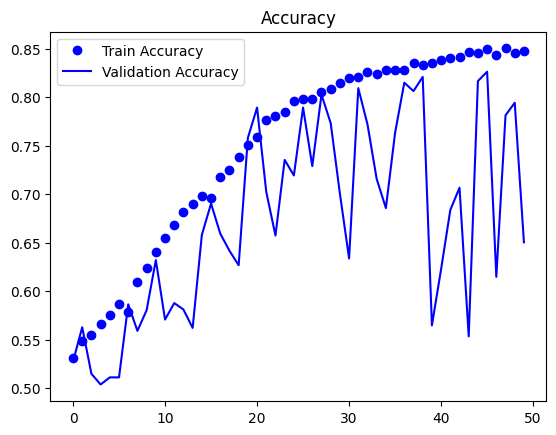

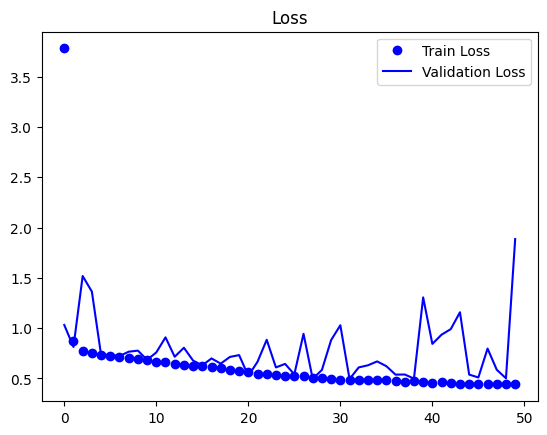

In [50]:
acc = alexNet_history.history['accuracy']
val_acc = alexNet_history.history['val_accuracy']
loss = alexNet_history.history['loss']
val_loss = alexNet_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()